# Colab preinstall

In [ ]:
!uv pip install ipympl
# restart to apply changes
import os
os.kill(os.getpid(), 9)

Using Python 3.11.13 environment at: /usr
Resolved 75 packages in 428ms
⠙ Preparing packages... (0/2)
⠙ Preparing packages... (0/2)
⠙ Preparing packages... (0/2)
⠙ Preparing packages... (0/2)
⠙ Preparing packages... (0/2)
⠙ Preparing packages... (0/2)
⠙ Preparing packages... (0/2)
⠙ Preparing packages... (0/2)
⠙ Preparing packages... (0/2)
⠙ Preparing packages... (0/2)
⠙ Preparing packages... (0/2)
ipympl     ------------------------------     0 B/503.62 KiB
⠙ Preparing packages... (0/2)
ipympl     ------------------------------ 16.00 KiB/503.62 KiB
⠙ Preparing packages... (0/2)
ipympl     ------------------------------ 16.00 KiB/503.62 KiB
⠙ Preparing packages... (0/2)
ipympl     ------------------------------ 32.00 KiB/503.62 KiB
⠙ Preparing packages... (0/2)
ipympl     ------------------------------ 48.00 KiB/503.62 KiB
⠙ Preparing packages... (0/2)
ipympl     ------------------------------ 61.80 KiB/503.62 KiB
⠙ Preparing packages... (0/2)
ipympl     ------------------------------ 

In [30]:
from google.colab import output
output.enable_custom_widget_manager()

# Imports

In [4]:
from numpy import dtype
import torch
import torch.functional as F
import matplotlib.pyplot as plt
import tqdm
from typing import Callable
from pathlib import Path

%matplotlib ipympl

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dtype = torch.float32

# Model definition. Same as in paper

In [5]:
non_linear_f = torch.nn.Tanh
layers_sizes = (2, 64, 128, 256, 256, 128, 64, 1)


class MyModel(torch.nn.Module):
    def __init__(self, dtype):
        super(MyModel, self).__init__()
        layers = []
        ins = layers_sizes[0]
        for clayer in layers_sizes[1:-1]:
            layers.append(torch.nn.Linear(ins, clayer, dtype=dtype))
            layers.append(non_linear_f())
            ins = clayer
        layers.append(torch.nn.Linear(ins, layers_sizes[-1]))
        self.layers = torch.nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)

In [6]:
# Using L1 loss because working with complex numbers, MSE does not support them
loss_f = torch.nn.MSELoss()

In [7]:
model = MyModel(dtype=dtype).to(device)

## Loading weights if they are exist

In [8]:
weights_path = "weights_rad2.pt"
if Path(weights_path).is_file():
    model.load_state_dict(torch.load(weights_path, map_location=device))
    model.eval()

# Problem

$$\frac{\partial u}{\partial t} = b \frac{\partial u}{\partial x}$$

$$exact: \sin{x - \beta t}$$

In [32]:
beta = 5
exact = lambda x, t: torch.sin(x - beta * t)

# Loss functions

In [10]:
def loss_IC(y_IC, x):
    # t = 0
    return loss_f(y_IC, exact(x, 0))

In [11]:
def residual(y, x, t):
    dudt = torch.autograd.grad(y, t, torch.ones_like(y, device=device, dtype=dtype), create_graph=True)[0]
    dudx = torch.autograd.grad(y, x, torch.ones_like(y, device=device, dtype=dtype), create_graph=True)[0]
    return dudt - beta * dudx

In [12]:
def loss_PDE(y, x, t):
    return loss_f(residual(y, x, t), torch.zeros_like(y))

In [13]:
def loss_BC(y, y_shifted):
    return loss_f(y, y_shifted)

In [14]:
def res_for_generate(x, y):
    x = x.clone()
    x.requires_grad = True
    y = y.clone()
    y.requires_grad = True
    xy = torch.vstack((x, y)).T
    z = model(xy).squeeze()
    return residual(z, x, y).abs()

In [ ]:
def res_data_for_generate(x, y):
    x = x.clone()
    x.requires_grad = True
    y = y.clone()
    y.requires_grad = True
    xy = torch.vstack((x, y)).T
    z = model(xy).squeeze()
    return (z - exact(x, y)).abs()

# TRAINING

# params

In [15]:
optim = torch.optim.AdamW(model.parameters(), lr=0.0001)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=1000)

In [16]:
x_bounds = (-0, 2 * torch.pi)
t_bounds = (0, 10)
EPOCHS_NUM = 5000
PDE_POINTS_NUM = 20000
IC_POINTS_NUM = 2000

## RAD

The algorithm of implementation is:
1. Throw some random points to area
2. Calculate function value for these points
3. Use torch.multinomial with replacement to sample points with respect to absolute function value
4. Create new points for each of sampled by adding some noise
5. Add some random points to explore more zones
6. Go to 2  

In [17]:
from typing import Callable


class RADPointGenerator:
    def __init__(
        self,
        func: Callable[[torch.Tensor, torch.Tensor], torch.Tensor],
        x_bounds,
        y_bounds,
        max_points=1000,
        min_explore_points=100,
        noise_factor=0.1,
        device="cpu",
        dtype=torch.float32,
    ):
        self.func = func
        self.x_bounds = x_bounds
        self.y_bounds = y_bounds
        self.device = device
        self.dtype=dtype
        self.max_points = max_points
        self.min_explore_points_n = min_explore_points
        self.n_points_to_generate = max_points - min_explore_points
        self.x_noise = (x_bounds[1] - x_bounds[0]) * noise_factor
        self.y_noise = (y_bounds[1] - y_bounds[0]) * noise_factor
        self.points_x, self.points_y = self.sample_uniform(self.max_points)

    def sample_uniform(self, n):
        x_min, x_max = self.x_bounds
        y_min, y_max = self.y_bounds
        xs = torch.empty(n, device=self.device, dtype=self.dtype).uniform_(x_min, x_max)
        ys = torch.empty(n, device=self.device, dtype=self.dtype).uniform_(y_min, y_max)

        return xs, ys

    def generate(self):
        x, y = self.points_x, self.points_y
        weights = self.func(x, y).abs()
        chosen_indexes = torch.multinomial(
            weights, self.n_points_to_generate, replacement=True
        )
        x_new: torch.Tensor = torch.clamp(
            x[chosen_indexes]
            + torch.empty(self.n_points_to_generate, device=self.device).uniform_(
                -self.x_noise, self.x_noise
            ),
            *self.x_bounds,
        )
        y_new: torch.Tensor = torch.clamp(
            y[chosen_indexes]
            + torch.empty(self.n_points_to_generate, device=self.device).uniform_(
                -self.y_noise, self.y_noise
            ),
            *self.y_bounds,
        )

        x_explore, y_explore = self.sample_uniform(self.min_explore_points_n)

        x_new = torch.cat((x_new, x_explore))
        y_new = torch.cat((y_new, y_explore))

        self.points_x = x_new
        self.points_y = y_new
        return x_new, y_new


In [ ]:
sampler_pde = RADPointGenerator(res_for_generate, x_bounds, t_bounds, max_points=PDE_POINTS_NUM, min_explore_points=PDE_POINTS_NUM // 10, device=device, noise_factor=0.00001)
sampler_data = RADPointGenerator(res_data_for_generate, x_bounds, t_bounds, max_points=PDE_POINTS_NUM, min_explore_points=PDE_POINTS_NUM // 10, device=device, noise_factor=0.00001)

In [ ]:
for i in tqdm.tqdm(range(EPOCHS_NUM)):
    x_pde, t_pde = sampler_pde.generate()
    x_pde = x_pde.clone()
    x_pde.requires_grad = True
    t_pde = t_pde.clone()
    t_pde.requires_grad = True
    xt_pde = torch.vstack((x_pde, t_pde)).T
    x_data, t_data = sampler_data.generate()
    x_data = x_data.clone()
    x_data.requires_grad = True
    t_fdata = t_data.clone()
    t_data.requires_grad = True
    xt_data = torch.vstack((x_data, t_data)).T
    x_ic = torch.rand(IC_POINTS_NUM, device=device) * (x_bounds[1] - x_bounds[0]) + x_bounds[0]
    x_ic.requires_grad = True
    t_ic = torch.zeros_like(x_ic)
    t_ic.requires_grad = True
    xt_ic = torch.vstack((x_ic, t_ic)).T
    x_bc = torch.zeros(IC_POINTS_NUM, device=device)
    x_bc.requires_grad = True
    x_bc2 = x_bc + torch.pi * 2
    # x_bc2.requires_grad = True
    t_bc = torch.empty_like(x_ic, device=device).uniform_(t_bounds[0], t_bounds[1])
    t_bc.requires_grad = True
    xt_bc = torch.stack((x_bc, t_bc), dim=1)
    xt_bc2 = torch.stack((x_bc2, t_bc), dim=1)
    optim.zero_grad()
    y_pde = model(xt_pde).squeeze()
    y_data = model(xt_data).squeeze()
    y_ic = model(xt_ic).squeeze()
    y_bc = model(xt_bc).squeeze()
    y_bc2 = model(xt_bc2).squeeze()
    closs = loss_PDE(y_pde, x_pde, t_pde) + loss_IC(y_ic, x_ic) + loss_BC(y_bc, y_bc2) + loss_f(y_data, exact(x_data, t_data))
    closs.backward()
    optim.step()
    lr_scheduler.step()
    if i % 100 == 0:
        print(closs, optim.param_groups[0]['lr'])

  0%|          | 4/5000 [00:00<06:39, 12.50it/s]

tensor(1.0230, device='cuda:0', grad_fn=<AddBackward0>) 1.0000000000000002e-07


  2%|▏         | 104/5000 [00:18<13:31,  6.03it/s]

tensor(1.2149, device='cuda:0', grad_fn=<AddBackward0>) 1.0000000000000002e-07


  4%|▍         | 204/5000 [00:38<13:42,  5.83it/s]

tensor(1.2042, device='cuda:0', grad_fn=<AddBackward0>) 1.0000000000000002e-07


  6%|▌         | 304/5000 [00:57<13:49,  5.66it/s]

tensor(1.1768, device='cuda:0', grad_fn=<AddBackward0>) 1.0000000000000002e-07


  8%|▊         | 401/5000 [01:18<14:56,  5.13it/s]

tensor(1.1051, device='cuda:0', grad_fn=<AddBackward0>) 1.0000000000000002e-07


KeyboardInterrupt: 

## random

In [ ]:
for i in tqdm.tqdm(range(EPOCHS_NUM)):
    x_pde = torch.rand(PDE_POINTS_NUM, device=device) * (x_bounds[1] - x_bounds[0]) + x_bounds[0]
    t_pde = torch.rand(PDE_POINTS_NUM, device=device) * (t_bounds[1] - t_bounds[0]) + t_bounds[0]
    x_pde.requires_grad = True
    t_pde.requires_grad = True
    xt_pde = torch.stack((x_pde, t_pde), dim=1)
    x_ic = torch.rand(IC_POINTS_NUM, device=device) * (x_bounds[1] - x_bounds[0]) + x_bounds[0]
    x_ic.requires_grad = True
    t_ic = torch.zeros_like(x_ic, device=device)
    t_ic.requires_grad = True
    xt_ic = torch.stack((x_ic, t_ic), dim=1)
    x_bc = torch.zeros(IC_POINTS_NUM, device=device)
    x_bc.requires_grad = True
    x_bc2 = x_bc + torch.pi * 2
    # x_bc2.requires_grad = True
    t_bc = torch.empty_like(x_ic, device=device).uniform_(t_bounds[0], t_bounds[1])
    t_bc.requires_grad = True
    xt_bc = torch.stack((x_bc, t_bc), dim=1)
    xt_bc2 = torch.stack((x_bc2, t_bc), dim=1)
    optim.zero_grad()
    y_pde = model(xt_pde).squeeze()
    y_ic = model(xt_ic).squeeze()
    y_bc = model(xt_bc).squeeze()
    y_bc2 = model(xt_bc2).squeeze()
    closs = loss_PDE(y_pde, x_pde, t_pde) + loss_IC(y_ic, x_ic) + loss_BC(y_bc, y_bc2) + loss_f(y_pde, exact(x_pde, t_pde))
    closs.backward()
    optim.step()
    lr_scheduler.step()
    if i % 100 == 0:
        print(closs, optim.param_groups[0]['lr'])

  0%|          | 5/5000 [00:00<05:36, 14.84it/s]

tensor(0.3164, device='cuda:0', grad_fn=<AddBackward0>) 0.0001


  2%|▏         | 101/5000 [00:15<22:05,  3.70it/s]

tensor(0.1735, device='cuda:0', grad_fn=<AddBackward0>) 0.0001


  4%|▍         | 201/5000 [00:30<22:10,  3.61it/s]

tensor(0.0757, device='cuda:0', grad_fn=<AddBackward0>) 0.0001


  6%|▌         | 301/5000 [00:45<22:13,  3.52it/s]

tensor(0.0662, device='cuda:0', grad_fn=<AddBackward0>) 0.0001


  8%|▊         | 401/5000 [01:01<22:16,  3.44it/s]

tensor(0.0532, device='cuda:0', grad_fn=<AddBackward0>) 0.0001


 10%|█         | 501/5000 [01:17<22:03,  3.40it/s]

tensor(0.0361, device='cuda:0', grad_fn=<AddBackward0>) 0.0001


 12%|█▏        | 601/5000 [01:34<21:49,  3.36it/s]

tensor(0.0275, device='cuda:0', grad_fn=<AddBackward0>) 0.0001


 14%|█▍        | 701/5000 [01:50<21:20,  3.36it/s]

tensor(0.0250, device='cuda:0', grad_fn=<AddBackward0>) 0.0001


 16%|█▌        | 801/5000 [02:07<21:06,  3.32it/s]

tensor(0.0199, device='cuda:0', grad_fn=<AddBackward0>) 0.0001


 18%|█▊        | 901/5000 [02:24<20:48,  3.28it/s]

tensor(0.0216, device='cuda:0', grad_fn=<AddBackward0>) 0.0001


 20%|██        | 1001/5000 [02:41<20:16,  3.29it/s]

tensor(0.0178, device='cuda:0', grad_fn=<AddBackward0>) 1e-05


 22%|██▏       | 1101/5000 [02:58<20:02,  3.24it/s]

tensor(0.0183, device='cuda:0', grad_fn=<AddBackward0>) 1e-05


 24%|██▍       | 1201/5000 [03:15<19:29,  3.25it/s]

tensor(0.0175, device='cuda:0', grad_fn=<AddBackward0>) 1e-05


 26%|██▌       | 1301/5000 [03:32<19:24,  3.18it/s]

tensor(0.0203, device='cuda:0', grad_fn=<AddBackward0>) 1e-05


 28%|██▊       | 1404/5000 [03:50<09:30,  6.31it/s]

tensor(0.0201, device='cuda:0', grad_fn=<AddBackward0>) 1e-05


 30%|███       | 1501/5000 [04:07<18:24,  3.17it/s]

tensor(0.0203, device='cuda:0', grad_fn=<AddBackward0>) 1e-05


 31%|███▏      | 1568/5000 [04:18<09:26,  6.06it/s]


KeyboardInterrupt: 

# pLOTTING

### Abs of residual printing (basicly this is error)

Very small values along full area

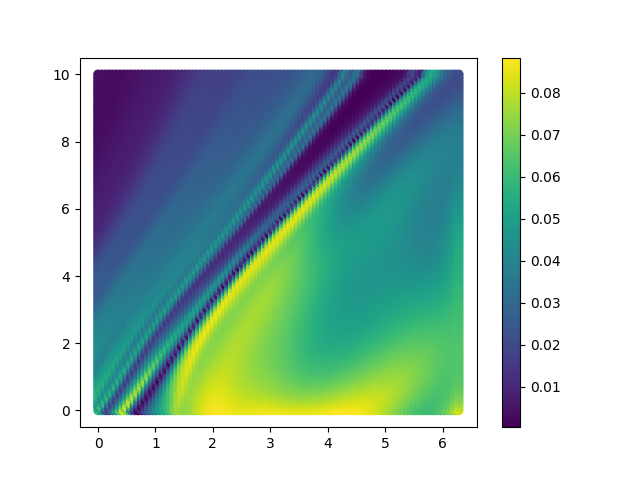

In [31]:
x_coords = torch.linspace(*x_bounds, 100, device=device, dtype=dtype)
y_coords = torch.linspace(*t_bounds, 100, device=device, dtype=dtype)
x_coords.requires_grad = True
y_coords.requires_grad = True
grid_x, grid_y = torch.meshgrid(x_coords, y_coords)
grid_x = grid_x.ravel()
grid_y = grid_y.ravel()
# 2. Evaluate the function at the initial grid points
# The function is expected to handle a batch of points
xy = torch.stack((grid_x, grid_y), dim=1)
guess = model(xy).ravel()
z = residual(guess, grid_x, grid_y)
# z = loss(z, torch.zeros_like(z, device=device, dtype=dtype))
z = z.abs()

# function_values = res_for_generate(grid_x, grid_y)
fig, ax = plt.subplots()
sc = ax.scatter(grid_x.cpu().detach(), grid_y.cpu().detach(), c=z.detach().cpu())
fig.colorbar(sc)

### test for sampling by rad implementation

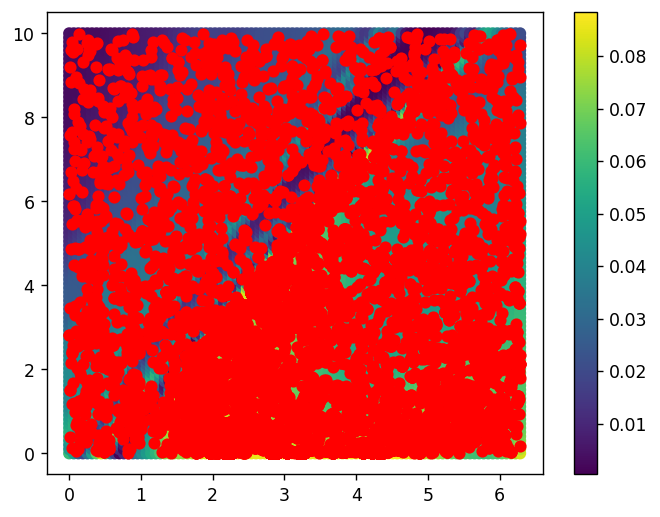

In [21]:
x, t = sampler.generate()
x = x.clone()
x.requires_grad = True
t = t.clone()
t.requires_grad = True
xy = torch.stack((x, t), dim=1)
z = model(xy).squeeze()
closs = torch.abs(residual(z, x, z))
# ax.scatter(x.cpu().detach(), t.cpu().detach(), c=closs.cpu().detach(), cmap="rainbow")
ax.scatter(x.cpu().detach(), t.cpu().detach(), c="red")
fig

### test of actual function for rad point generation 

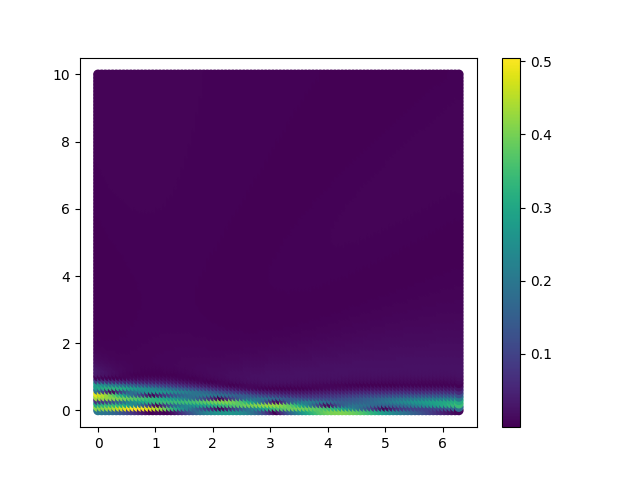

In [26]:
x_coords = torch.linspace(*x_bounds, 100, device=device, dtype=dtype)
y_coords = torch.linspace(*t_bounds, 100, device=device, dtype=dtype)
grid_x, grid_y = torch.meshgrid(x_coords, y_coords)

# 2. Evaluate the function at the initial grid points
# The function is expected to handle a batch of points
function_values = res_for_generate( grid_x.ravel(), grid_y.ravel())
plt.gcf().clear()
plt.scatter(grid_x.cpu().detach(), grid_y.cpu().detach(), c=function_values.cpu().detach())
plt.colorbar()
plt.show()


### Full area points generation with model values

In [33]:
t = torch.linspace(*t_bounds, 100, dtype=dtype, device=device)
t.requires_grad = True
x = torch.linspace(*x_bounds, 100, dtype=dtype, device=device)
x.requires_grad = True
grid_x, grid_t = torch.meshgrid(x, t)
shape = grid_x.shape
X = grid_x.ravel()
T = grid_t.ravel()
XT = torch.stack((X, T), dim=1)
Y = model(XT).ravel()
loss_y = torch.abs(residual(Y, X, T))

x = X.cpu().detach()
t = T.cpu().detach()
y = Y.cpu().detach()
grid_y = y.reshape(shape)
loss_y = loss_y.cpu().detach()
grid_loss_y = loss_y.reshape(shape)
grid_x = grid_x.cpu().detach()
grid_t = grid_t.cpu().detach()

/tmp/ipykernel_12966/1801097812.py:16: UserWarning: The following kwargs were not used by contour: 's'
  sc21 = ax21.contourf(grid_x, grid_t, grid_y, s=10)
/tmp/ipykernel_12966/1801097812.py:17: UserWarning: The following kwargs were not used by contour: 's'
  sc22 = ax22.contourf(grid_x, grid_t, grid_loss_y, s=10)
/tmp/ipykernel_12966/1801097812.py:18: UserWarning: The following kwargs were not used by contour: 's'
  sc23 = ax23.contourf(grid_x, grid_t, exact(grid_x, grid_t), s=10)


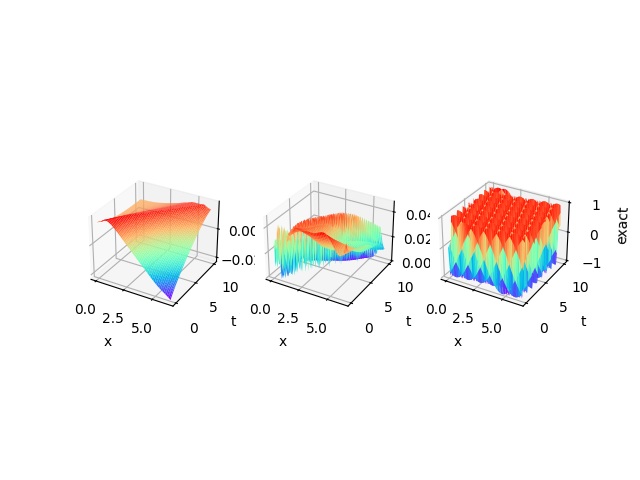

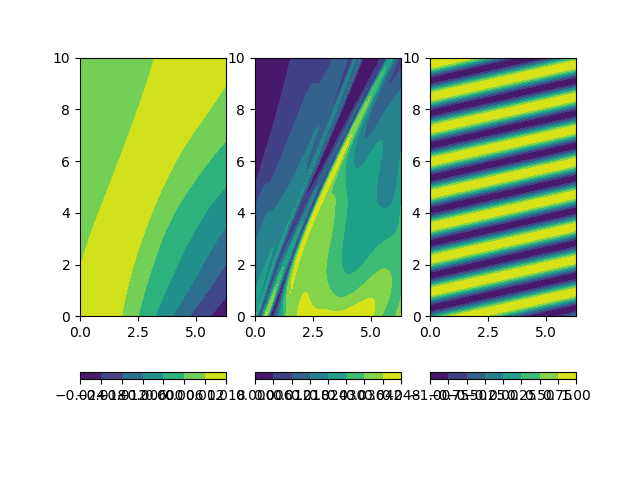

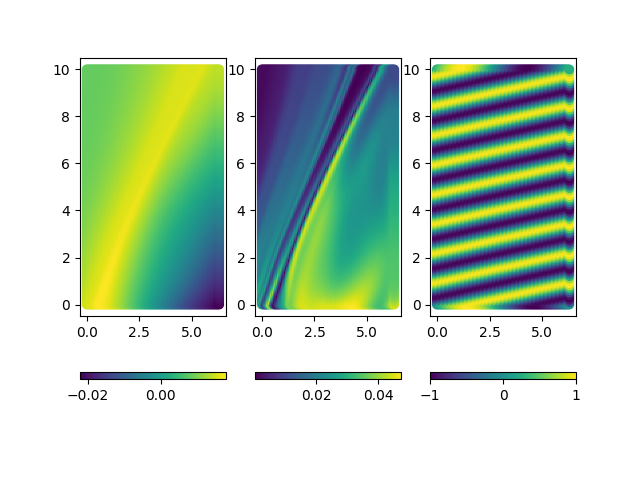

In [39]:
fig1, (ax31, ax32, ax33) = plt.subplots(1, 3, subplot_kw={'projection': '3d'})
fig2, (ax21, ax22, ax23) = plt.subplots(1, 3)
fig3, (ax11, ax12, ax13) = plt.subplots(1, 3)
ax31.set_xlabel('x')
ax31.set_ylabel('t')
ax31.set_zlabel('y')
ax32.set_xlabel('x')
ax32.set_ylabel('t')
ax32.set_zlabel('loss')
ax33.set_xlabel('x')
ax33.set_ylabel('t')
ax33.set_zlabel('exact')
ax31.plot_surface(grid_x, grid_t, grid_y, cmap="rainbow")
ax32.plot_surface(grid_x, grid_t, grid_loss_y, cmap="rainbow")
ax33.plot_surface(grid_x, grid_t, exact(grid_x, grid_t), cmap="rainbow")
sc21 = ax21.contourf(grid_x, grid_t, grid_y, s=10)
sc22 = ax22.contourf(grid_x, grid_t, grid_loss_y, s=10)
sc23 = ax23.contourf(grid_x, grid_t, exact(grid_x, grid_t), s=10)
fig2.colorbar(sc21, ax=ax21, orientation="horizontal")
fig2.colorbar(sc22, ax=ax22, orientation="horizontal")
fig2.colorbar(sc23, ax=ax23, orientation="horizontal")
sc11 = ax11.scatter(x, t, c=y)
sc12 = ax12.scatter(x, t, c=loss_y)
sc13 = ax13.scatter(x, t, c=exact(x, t))
fig3.colorbar(sc11, ax=ax11, orientation="horizontal")
fig3.colorbar(sc12, ax=ax12, orientation="horizontal")
fig3.colorbar(sc13, ax=ax13, orientation="horizontal")

/tmp/ipykernel_12966/3667105194.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor = torch.tensor(X.ravel(), dtype=dtype, device=device)
/tmp/ipykernel_12966/3667105194.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  T_tensor = torch.tensor(T.ravel(), dtype=dtype, device=device)


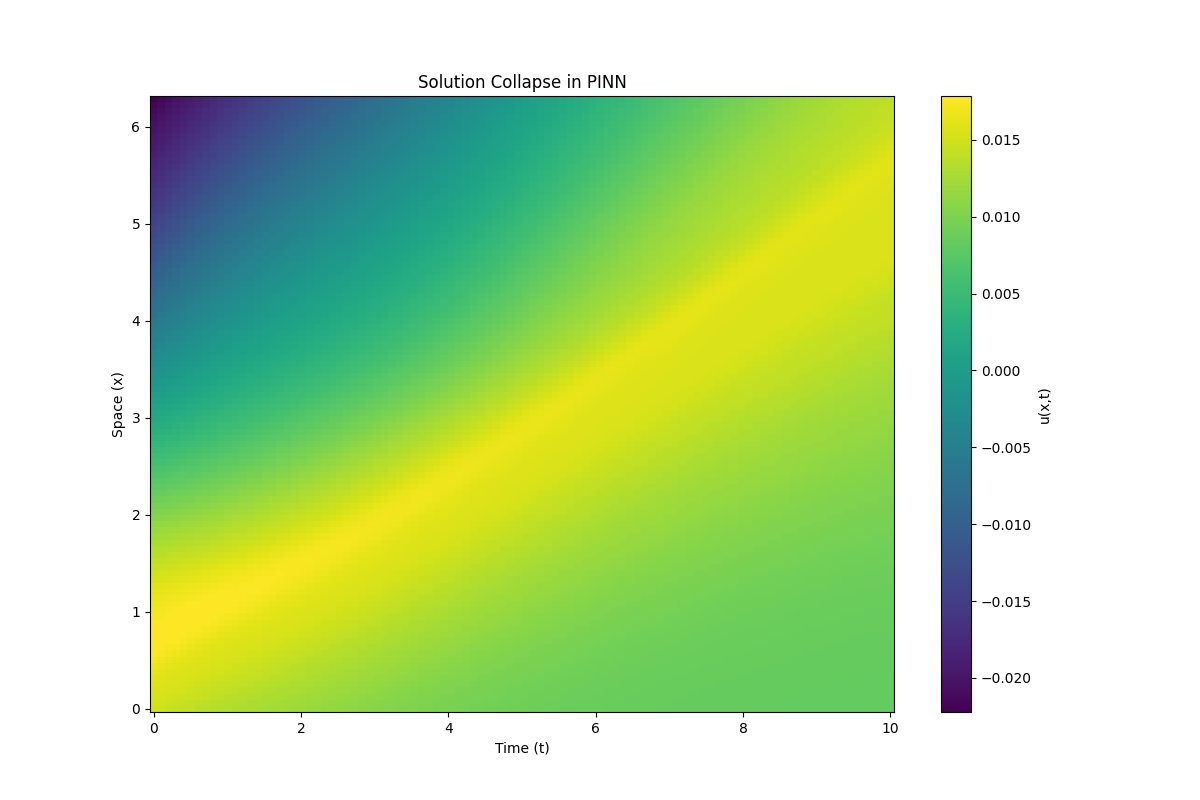

In [30]:
def visualize_solution(model):
    # 创建网格
    x = torch.linspace(*x_bounds, 100, device=device)
    t = torch.linspace(*t_bounds, 100, device=device)
    X, T = torch.meshgrid(x, t)

    # 预测解
    with torch.no_grad():
        X_tensor = torch.tensor(X.ravel(), dtype=dtype, device=device)
        T_tensor = torch.tensor(T.ravel(), dtype=dtype, device=device)
        XT = torch.stack((X_tensor, T_tensor), dim=1)
        U_pred = model(XT).cpu().numpy().reshape(X.shape)
    
    X = X.cpu()
    T = T.cpu()

    # 绘制解崩塌图
    plt.figure()
    plt.pcolormesh(T, X, U_pred, shading='auto', cmap='viridis')
    plt.colorbar(label='u(x,t)')
    plt.xlabel('Time (t)')
    plt.ylabel('Space (x)')
    plt.title('Solution Collapse in PINN')
    plt.show()

visualize_solution(model)

In [37]:
plt.close("all")

In [3]:
from gc import collect

torch.cuda.empty_cache(), collect()

(None, 24)

In [24]:
torch.save(model.state_dict(), "model.pt")